# EDA API

### Importación de librerías

In [1]:
import sys
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
sys.path.append(os.path.abspath('../source'))


### Descarga de Datos de Accidentes FARS desde la API de NHTSA

Primero, carga un par de herramientas: requests para conectarse a la API y os para manejar carpetas. Luego, define la dirección web base de la API y unos encabezados que hacen que parezca que la petición viene de un navegador. Crea una carpeta llamada ../data para guardar los archivos, y si ya existe, no hay problema.

Después, usa un bucle para recorrer los años de 2017 a 2022. Para cada año, arma una dirección web con los detalles necesarios (como el año y que queremos CSV) y hace la petición a la API. Si todo sale bien (código 200), guarda los datos en un archivo con nombre como FARS_data_año.csv. Si algo falla, muestra un mensaje con el problema, ya sea porque tardó mucho o por otro error.

In [2]:
base_url = "https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData"

# Encabezados
headers = {
    "Accept": "application/json", 
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}


output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)


for year in range(2017, 2023):  

    url = f"{base_url}?dataset=Accident&FromYear={year}&ToYear={year}&State=*&format=csv"
    print(f"Descargando datos para el año {year}...")

    try:
        # Realizar la solicitud al API
        response = requests.get(url, headers=headers, timeout=600, stream=True)  # Timeout de 10 minutos

        # Verificar si la solicitud fue exitosa
        if response.status_code == 200:
            # Guardar los datos en el archivo CSV
            output_file = os.path.join(output_dir, f"FARS_data_{year}.csv")
            with open(output_file, "wb") as file:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        file.write(chunk)
            print(f"Datos del año {year} guardados exitosamente en {output_file}")
        else:
            print(f"Error al obtener los datos para el año {year}: Código HTTP {response.status_code}")
            print(response.text)

    except requests.exceptions.Timeout:
        print(f"La solicitud para el año {year} excedió el tiempo límite.")
    except requests.exceptions.RequestException as e:
        print(f"Error en la solicitud para el año {year}: {e}")

Descargando datos para el año 2017...
Datos del año 2017 guardados exitosamente en ../data/FARS_data_2017.csv
Descargando datos para el año 2018...
Datos del año 2018 guardados exitosamente en ../data/FARS_data_2018.csv
Descargando datos para el año 2019...
Datos del año 2019 guardados exitosamente en ../data/FARS_data_2019.csv
Descargando datos para el año 2020...
Datos del año 2020 guardados exitosamente en ../data/FARS_data_2020.csv
Descargando datos para el año 2021...
Datos del año 2021 guardados exitosamente en ../data/FARS_data_2021.csv
Descargando datos para el año 2022...
Datos del año 2022 guardados exitosamente en ../data/FARS_data_2022.csv


#### Carga de Datos de Accidentes FARS desde Archivos CSV

para leer cada archivo CSV que está en la carpeta ../data. Cada archivo se guarda en una variable distinta: data_2017, data_2018, y así hasta data_2022. Estas variables quedan listas como tablas en la memoria para que las podamos analizar o usar después.

In [3]:
data_2017 = pd.read_csv('../data/FARS_data_2017.csv')
data_2018 = pd.read_csv('../data/FARS_data_2018.csv')
data_2019 = pd.read_csv('../data/FARS_data_2019.csv')
data_2020 = pd.read_csv('../data/FARS_data_2020.csv')
data_2021 = pd.read_csv('../data/FARS_data_2021.csv')
data_2022 = pd.read_csv('../data/FARS_data_2022.csv')

/tmp/ipykernel_143509/2599200083.py:1: DtypeWarning: Columns (41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2017 = pd.read_csv('../data/FARS_data_2017.csv')


#### Unión de Datos de Accidentes FARS desde Archivos CSV

Después, con pd.concat() junta todas esas tablas en una sola, llamada df. El ignore_index=True hace que los números de las filas se reinicien y no se mezclen los índices viejos. Por último, df.head() muestra las primeras 5 filas de la tabla para que veamos cómo quedó.

Esto es para unir todos los datasets en uno solo. Así, en lugar de tener los datos de cada año por separado, los tenemos en una sola tabla grande, más fácil de analizar o usar para sacar información.

In [4]:
df = pd.concat([data_2017, data_2018, data_2019, data_2020, data_2021, data_2022], ignore_index=True)
df.head()

,caseyear,state,st_case,statename,ve_total,ve_forms,pvh_invl,peds,pernotmvit,permvit,...,hosp_mn,hosp_mnname,cf1,cf1name,cf2,cf2name,cf3,cf3name,fatals,drunk_dr
0,2017,1,10001,Alabama,1,1,0,0,0,1,...,88,Not Applicable (Not Transported),0.0,NaN,0.0,NaN,0.0,NaN,1,0.0
1,2017,1,10002,Alabama,1,1,0,0,0,1,...,88,Not Applicable (Not Transported),0.0,NaN,0.0,NaN,0.0,NaN,1,0.0
2,2017,1,10003,Alabama,3,3,0,0,0,3,...,88,Not Applicable (Not Transported),0.0,NaN,0.0,NaN,0.0,NaN,1,0.0
3,2017,1,10004,Alabama,1,1,0,0,0,1,...,88,Not Applicable (Not Transported),20.0,Police Pursuit Involved,0.0,NaN,0.0,NaN,1,0.0
4,2017,1,10005,Alabama,1,1,0,0,0,2,...,11,11,0.0,NaN,0.0,NaN,0.0,NaN,1,0.0


### Generalidades

In [5]:
df.shape

(218777, 94)

Al ejecutar df.shape, se obtiene como resultado (218576, 93), lo que indica que el dataset contiene 218,576 registros (filas) y 93 variables (columnas). Esta cantidad significativa de datos proporciona la api es una base sólida para realizar un análisis exhaustivo sobre los accidentes de tránsito. La alta dimensionalidad también sugiere la presencia de múltiples factores que podrían influir en los siniestros viales. 

#### Tipos de Dtaos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218777 entries, 0 to 218776
Data columns (total 94 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   caseyear      218777 non-null  int64  
 1   state         218777 non-null  int64  
 2   st_case       218777 non-null  int64  
 3   statename     218777 non-null  object 
 4   ve_total      218777 non-null  int64  
 5   ve_forms      218777 non-null  int64  
 6   pvh_invl      218777 non-null  int64  
 7   peds          218777 non-null  int64  
 8   pernotmvit    218777 non-null  int64  
 9   permvit       218777 non-null  int64  
 10  persons       218777 non-null  int64  
 11  county        218777 non-null  int64  
 12  countyname    218777 non-null  object 
 13  city          218777 non-null  int64  
 14  cityname      218777 non-null  object 
 15  day           218777 non-null  int64  
 16  dayname       218777 non-null  int64  
 17  month         218777 non-null  int64  
 18  mont

Al ejecutar df.info(), se observa que el conjunto de datos está compuesto por 218,777 registros distribuidos en 94 columnas. Las variables presentan tres tipos de datos principales: int64 (43 columnas), float64 (10 columnas) y object (41 columnas), lo que indica una mezcla entre datos numéricos y categóricos.

Un aspecto relevante a destacar es la presencia de valores nulos en algunas variables. Por ejemplo, la columna drunk_dr, relacionada posiblemente con conducción bajo efectos del alcohol, contiene 138,981 valores no nulos, lo que implica una proporción considerable de datos faltantes que deberá abordarse en etapas posteriores de limpieza o imputación.

In [7]:
df.columns

Index(['caseyear', 'state', 'st_case', 'statename', 've_total', 've_forms',
       'pvh_invl', 'peds', 'pernotmvit', 'permvit', 'persons', 'county',
       'countyname', 'city', 'cityname', 'day', 'dayname', 'month',
       'monthname', 'year', 'day_week', 'day_weekname', 'hour', 'hourname',
       'minute', 'minutename', 'nhs', 'nhsname', 'rur_urb', 'rur_urbname',
       'func_sys', 'func_sysname', 'rd_owner', 'rd_ownername', 'route',
       'routename', 'tway_id', 'tway_id2', 'milept', 'mileptname', 'latitude',
       'latitudename', 'longitud', 'longitudname', 'sp_jur', 'sp_jurname',
       'harm_ev', 'harm_evname', 'man_coll', 'man_collname', 'reljct1',
       'reljct1name', 'reljct2', 'reljct2name', 'typ_int', 'typ_intname',
       'wrk_zone', 'wrk_zonename', 'road_fnc', 'road_fncname', 'rel_road',
       'rel_roadname', 'lgt_cond', 'lgt_condname', 'weather1', 'weather1name',
       'weather2', 'weather2name', 'weather', 'weathername', 'sch_bus',
       'sch_busname', 'rail', 'rai

Este listado permite identificar cada una de las variables disponibles, lo cual resulta fundamental para planificar las siguientes etapas del análisis, como la limpieza, transformación y exploración detallada de los datos.

### Limpieza

In [8]:
columns = [
    've_total', 'pernotmvit', 'permvit', 'fatals', 'peds',
    'hosp_hr', 'hosp_mn', 'arr_hour', 'arr_min',
    'year', 'monthname', 'day_weekname', 'hourname',
    'state', 'statename', 'rur_urbname', 'func_sysname', 'rel_roadname',
    'weathername', 'lgt_condname',
    'drunk_dr',
    'man_collname', 'harm_evname'
]

df = df[columns]


Luego de un análisis exploratorio preliminar de todas las variables disponibles, se seleccionó un subconjunto de 23 columnas consideradas más representativas para entender con mayor profundidad las causas y características de los accidentes de tránsito. Estas variables fueron almacenadas en la lista columns, y posteriormente se filtró el DataFrame original (df = df[columns]) para conservar únicamente esta selección.

Las columnas elegidas abarcan aspectos clave como:

Información del accidente: número total de vehículos involucrados (ve_total), número de peatones (peds), heridos (pernotmvit, permvit), y número de víctimas fatales (fatals).

Tiempo de respuesta y ocurrencia: hora de hospitalización (hosp_hr, hosp_mn), hora y minuto de llegada de los servicios de emergencia (arr_hour, arr_min), año, nombre del mes, día de la semana y hora del incidente.

Ubicación y contexto geográfico: estado (state, statename), zona urbana o rural (rur_urbname), y funcionalidad del sistema vial (func_sysname).

Condiciones externas: condiciones climáticas (weathername), iluminación (lgt_condname) y relación del accidente con el estado de la vía (rel_roadname).

Factores de riesgo: presencia de conducción bajo efectos del alcohol (drunk_dr), tipo de colisión (man_collname) y evento perjudicial principal (harm_evname).

Esta selección de variables permite reducir la dimensionalidad sin perder información crítica, y a la vez amplía el contexto analítico del dataset original, facilitando una mejor interpretación de los factores que intervienen en un accidente de tránsito.

In [9]:
df.head()

,ve_total,pernotmvit,permvit,fatals,peds,hosp_hr,hosp_mn,arr_hour,arr_min,year,...,state,statename,rur_urbname,func_sysname,rel_roadname,weathername,lgt_condname,drunk_dr,man_collname,harm_evname
0,1,0,1,1,0,88,88,99,99,2017,...,1,Alabama,Urban,Interstate,On Median,Clear,Dark - Not Lighted,0.0,Not a Collision with Motor Vehicle In-Transport,Fence
1,1,0,1,1,0,88,88,15,9,2017,...,1,Alabama,Urban,Interstate,On Median,Clear,Daylight,0.0,Not a Collision with Motor Vehicle In-Transport,Rollover/Overturn
2,3,0,3,1,0,88,88,99,99,2017,...,1,Alabama,Urban,Interstate,On Roadway,Clear,Dark - Not Lighted,0.0,Front-to-Rear,Motor Vehicle In-Transport
3,1,0,1,1,0,88,88,16,58,2017,...,1,Alabama,Urban,Minor Arterial,On Roadside,Rain,Dark - Lighted,0.0,Not a Collision with Motor Vehicle In-Transport,Utility Pole/Light Support
4,1,0,2,1,0,21,11,20,31,2017,...,1,Alabama,Rural,Interstate,On Median,Rain,Dark - Not Lighted,0.0,Not a Collision with Motor Vehicle In-Transport,Embankment


In [10]:
df.dtypes

ve_total          int64
pernotmvit        int64
permvit           int64
fatals            int64
peds              int64
hosp_hr           int64
hosp_mn           int64
arr_hour          int64
arr_min           int64
year              int64
monthname        object
day_weekname     object
hourname         object
state             int64
statename        object
rur_urbname      object
func_sysname     object
rel_roadname     object
weathername      object
lgt_condname     object
drunk_dr        float64
man_collname     object
harm_evname      object
dtype: object

Se observa una estructura diversa que refleja la naturaleza heterogénea del dataset. En total, se identifican tres tipos de datos principales:

int64: presente en la mayoría de las variables numéricas (por ejemplo, ve_total, fatals, arr_hour, year), representa valores enteros y cuantificables relacionados con el número de vehículos, víctimas, tiempos y códigos.

float64: utilizado únicamente en la columna drunk_dr, lo cual sugiere que esta variable puede contener valores decimales o valores nulos (NaN), típicos de datos que requieren imputación o limpieza adicional.

object: abarca las variables categóricas como monthname, day_weekname, statename, weathername, entre otras

#### Manejo de datos de faltantes

In [11]:
df.isnull().sum()

ve_total            0
pernotmvit          0
permvit             0
fatals              0
peds                0
hosp_hr             0
hosp_mn             0
arr_hour            0
arr_min             0
year                0
monthname           0
day_weekname        0
hourname            0
state               0
statename           0
rur_urbname         0
func_sysname        0
rel_roadname        0
weathername         0
lgt_condname        0
drunk_dr        79796
man_collname        0
harm_evname         0
dtype: int64

Al aplicar el método df.isnull().sum(), se identificó la existencia de valores nulos únicamente en la columna drunk_dr, con un total de 79,796 registros faltantes. Esto representa una proporción considerable dentro del total de 218,777 observaciones, lo cual es relevante ya que dicha variable indica si hubo conductores ebrios involucrados en el accidente.

El resto de las columnas analizadas no presentan valores nulos, lo cual es positivo y facilita la continuidad del análisis sin necesidad de una limpieza extensa.

In [12]:
null_drunk_df = df[df['drunk_dr'].isnull()]

# Ver primeras filas (puedes ajustar el número si quieres ver más)
print(null_drunk_df.head(10))

# Mostrar cuántas filas tienen 'drunk_dr' nulo
print(f"\n🔍 Total de registros con drunk_dr nulo: {null_drunk_df.shape[0]}")


        ve_total  pernotmvit  permvit  fatals  peds  hosp_hr  hosp_mn  \
138981         2           0        3       2     0       23        2   
138982         1           0        2       2     0       88       88   
138983         1           1        1       1     1       88       88   
138984         1           0        1       1     0       99       99   
138985         2           0        4       1     0       88       88   
138986         3           0        3       1     0       12       53   
138987         1           0        1       1     0       88       88   
138988         2           0        2       1     0       88       88   
138989         1           0        2       1     0       99       99   
138990         3           0        3       1     0       99       99   

        arr_hour  arr_min  year  ... state statename rur_urbname  \
138981        22       25  2021  ...     1   Alabama       Urban   
138982        19        9  2021  ...     1   Alabama       U

In [13]:
if df['drunk_dr'].isnull().any():
    df['drunk_dr'] = df['drunk_dr'].fillna(0.0)
    print("Valores nulos en 'drunk_dr' reemplazados por 0.0")
else:
    print("'drunk_dr' no contiene valores nulos")

Valores nulos en 'drunk_dr' reemplazados por 0.0


Se imputaron los valores faltantes en la variable drunk_dr con 0.0, bajo el supuesto conservador de que la ausencia de reporte sobre conducción bajo efectos del alcohol puede interpretarse como “no se detectó alcohol”. 

In [14]:
df.isnull().sum()

ve_total        0
pernotmvit      0
permvit         0
fatals          0
peds            0
hosp_hr         0
hosp_mn         0
arr_hour        0
arr_min         0
year            0
monthname       0
day_weekname    0
hourname        0
state           0
statename       0
rur_urbname     0
func_sysname    0
rel_roadname    0
weathername     0
lgt_condname    0
drunk_dr        0
man_collname    0
harm_evname     0
dtype: int64

In [15]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

Se verifica nuevamente si existen datos nulos en el dataset usando el código nos da Como resultado, se confirma que no hay valores nulos en ninguna columna.

In [16]:
df.shape

(218777, 23)

#### Manejo de datos duplicados

In [17]:
df.duplicated().sum()

166

In [18]:
df[df.duplicated()]

,ve_total,pernotmvit,permvit,fatals,peds,hosp_hr,hosp_mn,arr_hour,arr_min,year,...,state,statename,rur_urbname,func_sysname,rel_roadname,weathername,lgt_condname,drunk_dr,man_collname,harm_evname
4339,1,1,1,1,1,88,88,99,99,2017,...,6,California,Urban,Principal Arterial - Other,On Roadway,Clear,Dark - Lighted,0.0,Not a Collision with Motor Vehicle In-Transport,Pedestrian
4597,1,1,1,1,1,99,99,99,99,2017,...,6,California,Urban,Principal Arterial - Other,On Roadway,Clear,Dark - Lighted,0.0,Not a Collision with Motor Vehicle In-Transport,Pedestrian
4725,1,1,1,1,1,88,88,99,99,2017,...,6,California,Urban,Minor Arterial,On Roadway,Clear,Dark - Lighted,0.0,Not a Collision with Motor Vehicle In-Transport,Pedestrian
4760,1,1,1,1,1,99,99,99,99,2017,...,6,California,Urban,Principal Arterial - Other,On Roadway,Clear,Dark - Lighted,0.0,Not a Collision with Motor Vehicle In-Transport,Pedestrian
4984,1,1,1,1,1,99,99,99,99,2017,...,6,California,Urban,Principal Arterial - Other,On Roadway,Clear,Dark - Lighted,0.0,Not a Collision with Motor Vehicle In-Transport,Pedestrian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213190,2,0,3,1,0,99,99,99,99,2022,...,48,Texas,Urban,Principal Arterial - Other,On Roadway,Clear,Dark - Lighted,0.0,Front-to-Front,Motor Vehicle In-Transport
213582,1,1,1,1,1,88,88,99,98,2022,...,48,Texas,Urban,Interstate,On Roadway,Clear,Dark - Lighted,0.0,The First Harmful Event was Not a Collision wi...,Pedestrian
213804,1,0,1,1,0,88,88,99,98,2022,...,48,Texas,Urban,Principal Arterial - Other,Outside Trafficway,Clear,Dark - Not Lighted,0.0,The First Harmful Event was Not a Collision wi...,Fence
214583,1,1,1,1,1,88,88,99,99,2022,...,48,Texas,Urban,Principal Arterial - Other,On Roadway,Clear,Dark - Lighted,0.0,The First Harmful Event was Not a Collision wi...,Pedestrian


Es importante identificar cuántos registros duplicados existen en el dataset para evitar distorsiones en los análisis posteriores. En este caso, se encontraron 91 datos duplicados, los cuales podrían influir negativamente en los resultados si no se eliminan adecuadamente. 

In [19]:
df = df.drop_duplicates()

Después de identificar los datos duplicados en el dataset, se procede a eliminarlos usando drop_duplicates() con el fin de mantener la integridad de los datos y asegurar que el análisis posterior no se vea afectado por información repetida.

In [20]:
df.shape

(218611, 23)

Después de eliminar los datos duplicados, nos quedamos con 218,611 filas y 23 columnas. Esto sigue representando una cantidad significativa de datos, lo cual es adecuado para realizar un análisis confiable y detallado.

In [21]:
df['hourname'].value_counts()    

hourname
6:00pm-6:59pm      12904
8:00pm-8:59pm      12823
9:00pm-9:59pm      12801
7:00pm-7:59pm      12408
5:00pm-5:59pm      11843
10:00pm-10:59pm    11183
4:00pm-4:59pm      10951
3:00pm-3:59pm      10859
11:00pm-11:59pm     9993
2:00pm-2:59pm       9921
1:00pm-1:59pm       8896
0:00am-0:59am       8746
12:00pm-12:59pm     8435
2:00am-2:59am       8044
6:00am-6:59am       8043
1:00am-1:59am       7930
11:00am-11:59am     7451
7:00am-7:59am       7126
5:00am-5:59am       6883
10:00am-10:59am     6620
3:00am-3:59am       5998
8:00am-8:59am       5851
9:00am-9:59am       5837
4:00am-4:59am       5435
Unknown Hours       1630
Name: count, dtype: int64

Al analizar la frecuencia de accidentes según la franja horaria (hourname), se observa que la mayoría de los siniestros ocurren entre 6:00pm y 6:59pm, con un total de 8145 registros.
Le siguen muy de cerca otras franjas del horario nocturno, como 8:00pm-8:59pm (8123 casos) y 9:00pm-9:59pm (8053 casos), lo que indica una alta concentración de accidentes durante el periodo de la tarde-noche, probablemente relacionado con el regreso a casa y el aumento del tráfico.
Además, se identificaron 1035 registros con hora desconocida, lo cual representa una porción menor del total, pero importante de tener en cuenta para futuras limpiezas o análisis de calidad de los datos.

In [22]:
df.drop(df[df['hourname'] == 'Unknown Hours'].index, inplace = True)

Se eliminan los registros cuya franja horaria corresponde a 'Unknown Hours', ya que no se dispone de información precisa sobre la hora del accidente. Esta decisión se toma con el fin de mantener la integridad de los datos y asegurar una mayor coherencia en los análisis posteriores relacionados con el comportamiento temporal de los accidentes.


In [23]:
df['rur_urbname'].value_counts()    

rur_urbname
Urban                                125927
Rural                                 90398
Trafficway Not in State Inventory       429
Unknown                                 180
Not Reported                             47
Name: count, dtype: int64

Al analizar la variable 'rur_urbname', se observa que la mayoría de los accidentes ocurren en zonas urbanas (78,065 casos), seguidas por zonas rurales (59,366 casos). También se identifican algunos registros con valores no específicos: 'Trafficway Not in State Inventory', 'Unknown' y 'Not Reported', lo cual indica que en ciertos casos no se tiene claridad sobre el tipo de zona donde ocurrió el accidente. Esto podría afectar ligeramente los análisis espaciales si no se depuran o tratan adecuadamente esos valores.

In [24]:
df.drop(df[df["rur_urbname"] == "Not Reported"].index, inplace=True)
df.drop(df[df["rur_urbname"] == "Trafficway Not in State Inventory"].index, inplace=True)
df.drop(df[df["rur_urbname"] == "Unknown"].index, inplace=True)

Como se identificó previamente, algunos registros en la columna 'rur_urbname' contenían valores como 'Not Reported', 'Trafficway Not in State Inventory' y 'Unknown', los cuales no aportan información específica ni útil para el análisis. Por esta razón, se decidió eliminar estas filas del dataset, con el objetivo de mantener la calidad, consistencia y relevancia de los datos para los análisis posteriores.

In [25]:
df['weathername'].value_counts()  

weathername
Clear                       152764
Cloudy                       29348
Rain                         15577
Not Reported                 12269
Fog, Smog, Smoke              2399
Snow                          1986
Reported as Unknown            644
Severe Crosswinds              352
Sleet or Hail                  260
Other                          212
Freezing Rain or Drizzle       181
Blowing Snow                   179
Unknown                         93
Blowing Sand, Soil, Dirt        61
Name: count, dtype: int64

Al analizar la variable 'weathername', se observa que la mayoría de los accidentes ocurrieron en condiciones climáticas despejadas ('Clear'), con un total de 94,275 registros. Esto sugiere que el clima no siempre es un factor determinante en la ocurrencia de accidentes, aunque otras condiciones como 'Rain', 'Cloudy' o 'Fog, Smog, Smoke' también presentan cantidades considerables.

Además, se identificaron categorías como 'Not Reported', 'Reported as Unknown' y 'Unknown', que no aportan información específica sobre el clima. Estos valores deben ser tenidos en cuenta para una limpieza del dataset, con el fin de garantizar mayor integridad y utilidad en los análisis posteriores.

In [26]:
df.drop(df[df["weathername"] == "Not Reported"].index, inplace=True)
df.drop(df[df["weathername"] == "Other"].index, inplace=True)
df.drop(df[df["weathername"] == "Unknown"].index, inplace=True)
df.drop(df[df["weathername"] == "Reported as Unknown"].index, inplace=True)

Como ya se había identificado en el análisis previo, existen valores en la variable 'weathername' que no aportan información específica o relevante, como 'Not Reported', 'Other', 'Unknown' y 'Reported as Unknown'. Por esta razón, se decidió eliminar estos registros del dataset. Esta limpieza permite mantener la coherencia y la integridad de los datos, lo cual es fundamental para obtener resultados más precisos y significativos en los análisis posteriores.

In [27]:
df.shape

(203107, 23)

Después de realizar el proceso de limpieza  que incluyó la eliminación de datos nulos, registros duplicados y valores categóricos no informativos el dataset final quedó con 203,107 filas y 23 columnas. Este nuevo tamaño sigue siendo lo suficientemente representativo para realizar un análisis estadístico confiable y significativo.

### estadística descriptiva 

In [28]:
df.describe(include="object")

,monthname,day_weekname,hourname,statename,rur_urbname,func_sysname,rel_roadname,weathername,lgt_condname,man_collname,harm_evname
count,203107,203107,203107,203107,203107,203107,203107,203107,203107,203107,203107
unique,12,7,24,52,2,9,14,10,10,14,60
top,October,Saturday,9:00pm-9:59pm,California,Urban,Principal Arterial - Other,On Roadway,Clear,Daylight,The First Harmful Event was Not a Collision wi...,Motor Vehicle In-Transport
freq,18883,35034,12060,21890,119060,60593,128309,152764,93816,83947,80778


El análisis descriptivo de las variables categóricas revela patrones contundentes en la ocurrencia de los accidentes.
Julio es el mes con más siniestros, mientras que el sábado es el día con mayor frecuencia de casos reportados. La franja horaria más crítica es entre 6:00pm y 6:59pm, lo que podría relacionarse con el tráfico de la tarde-noche.
El estado con más registros es California, lo cual puede estar relacionado con su alta densidad poblacional y tráfico vehicular.
La mayoría de los accidentes se presentan en zonas urbanas, en vías arteriales principales, sobre la calzada, bajo condiciones climáticas despejadas y en horas del día con luz natural.
Este conjunto de datos muestra con claridad que los accidentes tienden a concentrarse en contextos urbanos con condiciones aparentemente normales, lo que sugiere que el comportamiento humano y o de otras variables podrían ser factores clave en la ocurrencia de estos eventos.

### Limpieza de variables de tiempo

In [29]:
import numpy as np

# Diccionario con códigos especiales por columna
special_codes = {
    'arr_hour': [88, 99],
    'arr_min': [88, 97, 98, 99],
    'hosp_hr': [88, 99],
    'hosp_mn': [88, 96, 97, 98, 99]
}

# Crear columnas limpias reemplazando códigos especiales por NaN
for col, codes in special_codes.items():
    df[f'{col}_clean'] = df[col].replace({code: np.nan for code in codes})





Las siguientes variables de tiempo del dataset FARS fueron procesadas para eliminar códigos especiales o valores fuera del rango válido:

- `arr_hour`: hora de llegada
- `arr_min`: minuto de llegada
- `hosp_hr`: hora de hospitalización
- `hosp_mn`: minuto de hospitalización

Estas variables contenían códigos utilizados por el sistema FARS para representar valores especiales:

| Código | Significado común en FARS |
|--------|----------------------------|
| `88`   | Not Applicable             |
| `96`   | Anómalo (fuera de rango)   |
| `97`   | Imputed                    |
| `98`   | Estimated                  |
| `99`   | Unknown / Missing          |

Estos códigos fueron reemplazados por `NaN` en nuevas columnas auxiliares con sufijo `_clean` para preservar la integridad del análisis numérico y temporal.

Por ejemplo:
- `arr_min` contenía valores como `97`, `98`, `99`, que no representan minutos válidos.
- `hosp_mn` además incluía `96`, que también fue tratado como valor inválido.

Las columnas originales se conservaron para trazabilidad.


In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ve_total,203107.0,1.587936,0.835571,1.0,1.0,1.0,2.0,59.0
pernotmvit,203107.0,0.246845,0.532519,0.0,0.0,0.0,0.0,73.0
permvit,203107.0,2.228938,1.750472,0.0,1.0,2.0,3.0,128.0
fatals,203107.0,1.085999,0.351980,1.0,1.0,1.0,1.0,20.0
peds,203107.0,0.235792,0.506400,0.0,0.0,0.0,0.0,73.0
hosp_hr,203107.0,74.039043,34.929757,0.0,88.0,88.0,99.0,99.0
hosp_mn,203107.0,77.892318,29.406813,0.0,88.0,88.0,99.0,99.0
arr_hour,203107.0,58.520962,43.015459,0.0,15.0,99.0,99.0,99.0
arr_min,203107.0,66.424456,36.491445,0.0,32.0,98.0,99.0,99.0
year,203107.0,2019.624252,1.725950,2017.0,2018.0,2020.0,2021.0,2022.0


El análisis descriptivo de las variables numéricas ofrece información clave sobre las características de los accidentes registrados. A continuación se destacan algunos hallazgos relevantes:

**ve_total**:  
El número promedio de vehículos involucrados en un accidente es de aproximadamente **1.59**, con la mayoría de los casos implicando solo un vehículo. Sin embargo, se registran casos extremos con hasta **59 vehículos**, lo que indica la existencia de **accidentes múltiples o en cadena**.

**pernotmvit** y **permvit**:  
En promedio, hay alrededor de **2.24 personas heridas** en cada accidente y **0.24 personas no motorizadas** (peatones, ciclistas) involucradas. Esto muestra que, aunque la mayoría de los casos afectan solo a personas dentro de los vehículos, también hay participación de **usuarios vulnerables de la vía**.

**fatals**:  
Todos los accidentes en el conjunto de datos tienen al menos una fatalidad, con un promedio de **1.08 víctimas fatales** por caso. En los extremos, hay eventos con hasta **20 fallecidos**, lo cual resalta la gravedad de ciertos siniestros.

**peds**:  
Los peatones participan en una proporción menor de los accidentes, con un promedio de **0.23 por caso**, aunque se encuentran eventos con hasta **73 peatones involucrados**, posiblemente en zonas de alta afluencia peatonal.

**hosp_hr** y **hosp_mn** (originales):  
Estas variables representan tiempos de hospitalización o atención médica. Las medias son altas (**74 y 77** respectivamente), lo cual se debe a la presencia de valores codificados como **88, 96–99**, que podrían indicar datos faltantes, desconocidos o "no aplicables".

**hosp_hr_clean** y **hosp_mn_clean**:  
Una vez limpiados estos valores especiales, las medias bajan considerablemente (**13.57 y 29.18**), lo que representa de manera más realista la **hora y minuto del traslado o atención médica**. Estos valores ahora caen dentro de rangos esperables (0–23 horas y 0–59 minutos).

**arr_hour** y **arr_min** (originales):  
Al igual que las variables anteriores, presentan valores máximos de **99**, probablemente codificados como "valor desconocido". Las medias originales están distorsionadas (**58 y 66**), lo que justifica la limpieza.

**arr_hour_clean** y **arr_min_clean**:  
Las versiones corregidas muestran una media de **13.07 horas y 29.41 minutos**, lo cual es más razonable y representa de forma más precisa los **tiempos de arribo de emergencia** al sitio del accidente.

**year**:  
Los datos abarcan de 2017 a 2022, con una media de **2019.6**, lo que refleja una **ventana temporal amplia**, con cierta concentración en los últimos años antes de 2022.

**state**:  
Se observan datos provenientes de **todos los estados de EE.UU.**, con identificadores numéricos de 1 a 56, lo que confirma una **cobertura nacional**.

**drunk_dr**:  
El promedio de conductores ebrios por accidente es de **0.17**, lo que sugiere que, aunque no son mayoría, el alcohol está presente en una **fracción significativa** de los casos. Muchos valores faltantes fueron imputados como 0.0, asumiendo ausencia de evidencia de alcohol, lo que **reduce la media y puede subestimar ligeramente la prevalencia real**

In [31]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

outlier_log = []

for col in numerical_cols:
    print(f"\n--- Analyzing Outliers for '{col}' ---")

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    num_outliers = len(outliers)

    print(f"Number of Outliers: {num_outliers}")
    print(f"Lower Limit: {lower_limit:.2f}, Upper Limit: {upper_limit:.2f}")

    outlier_log.append({
        'Variable': col,
        'Outliers': num_outliers,
        'Lower Limit': lower_limit,
        'Upper Limit': upper_limit,
        'Porcentaje de Outliers': round(num_outliers / len(df) * 100, 2)
    })

print("\nResumen de Outliers:")
print(outlier_log)



--- Analyzing Outliers for 've_total' ---
Number of Outliers: 4914
Lower Limit: -0.50, Upper Limit: 3.50

--- Analyzing Outliers for 'pernotmvit' ---
Number of Outliers: 45789
Lower Limit: 0.00, Upper Limit: 0.00

--- Analyzing Outliers for 'permvit' ---
Number of Outliers: 5008
Lower Limit: -2.00, Upper Limit: 6.00

--- Analyzing Outliers for 'fatals' ---
Number of Outliers: 14292
Lower Limit: 1.00, Upper Limit: 1.00

--- Analyzing Outliers for 'peds' ---
Number of Outliers: 44643
Lower Limit: 0.00, Upper Limit: 0.00

--- Analyzing Outliers for 'hosp_hr' ---
Number of Outliers: 49777
Lower Limit: 71.50, Upper Limit: 115.50

--- Analyzing Outliers for 'hosp_mn' ---
Number of Outliers: 49664
Lower Limit: 71.50, Upper Limit: 115.50

--- Analyzing Outliers for 'arr_hour' ---
Number of Outliers: 0
Lower Limit: -111.00, Upper Limit: 225.00

--- Analyzing Outliers for 'arr_min' ---
Number of Outliers: 0
Lower Limit: -68.50, Upper Limit: 199.50

--- Analyzing Outliers for 'year' ---
Number o

Se aplicó el método del rango intercuartílico (IQR) para identificar valores atípicos en las variables numéricas del conjunto de datos. A continuación se presentan los hallazgos más destacados:

‘ve_total’ (vehículos involucrados): Presenta un 2.4% de valores atípicos, principalmente en registros donde hay más de 3 vehículos implicados, lo que indica eventos de colisión múltiple o en cadena.

‘pernotmvit’ y ‘peds’ (personas no motorizadas y peatones): Ambos campos muestran más del 20% de outliers, debido a que la mayoría de los registros tienen valor 0 y cualquier valor superior es identificado como atípico, aunque en realidad estos casos sí representan eventos importantes (con peatones o ciclistas).

‘permvit’ (personas motorizadas involucradas): Cerca del 2.5% de los datos se consideran atípicos, en su mayoría cuando hay más de 6 personas afectadas en un solo accidente.

‘fatals’ (víctimas fatales): El 7% de los registros se consideran atípicos porque todos los valores diferentes a 1 se clasifican como tales, lo que en este caso refleja accidentes más graves de lo habitual.

Variables como ‘hosp_hr’, ‘hosp_mn’, ‘arr_hour’, ‘arr_min’, ‘year’, ‘state’: No presentan valores atípicos según el IQR, lo cual indica una distribución controlada y dentro de los límites esperados.

‘drunk_dr’ (conductores ebrios): Se detectaron 13 valores atípicos (0.01%), todos mayores a 2.5, lo que sugiere que hubo accidentes con más de dos conductores en estado de embriaguez, una situación extrema pero posible.

La presencia de outliers en ciertas variables no necesariamente indica errores, sino que en muchos casos representa eventos extremos reales que deben conservarse para no perder información valiosa sobre situaciones de alto riesgo. Sin embargo, es importante considerar su impacto en futuros modelos estadísticos o de predicción.

## Visualizaciones

Grafico de barras par las variables numericas 

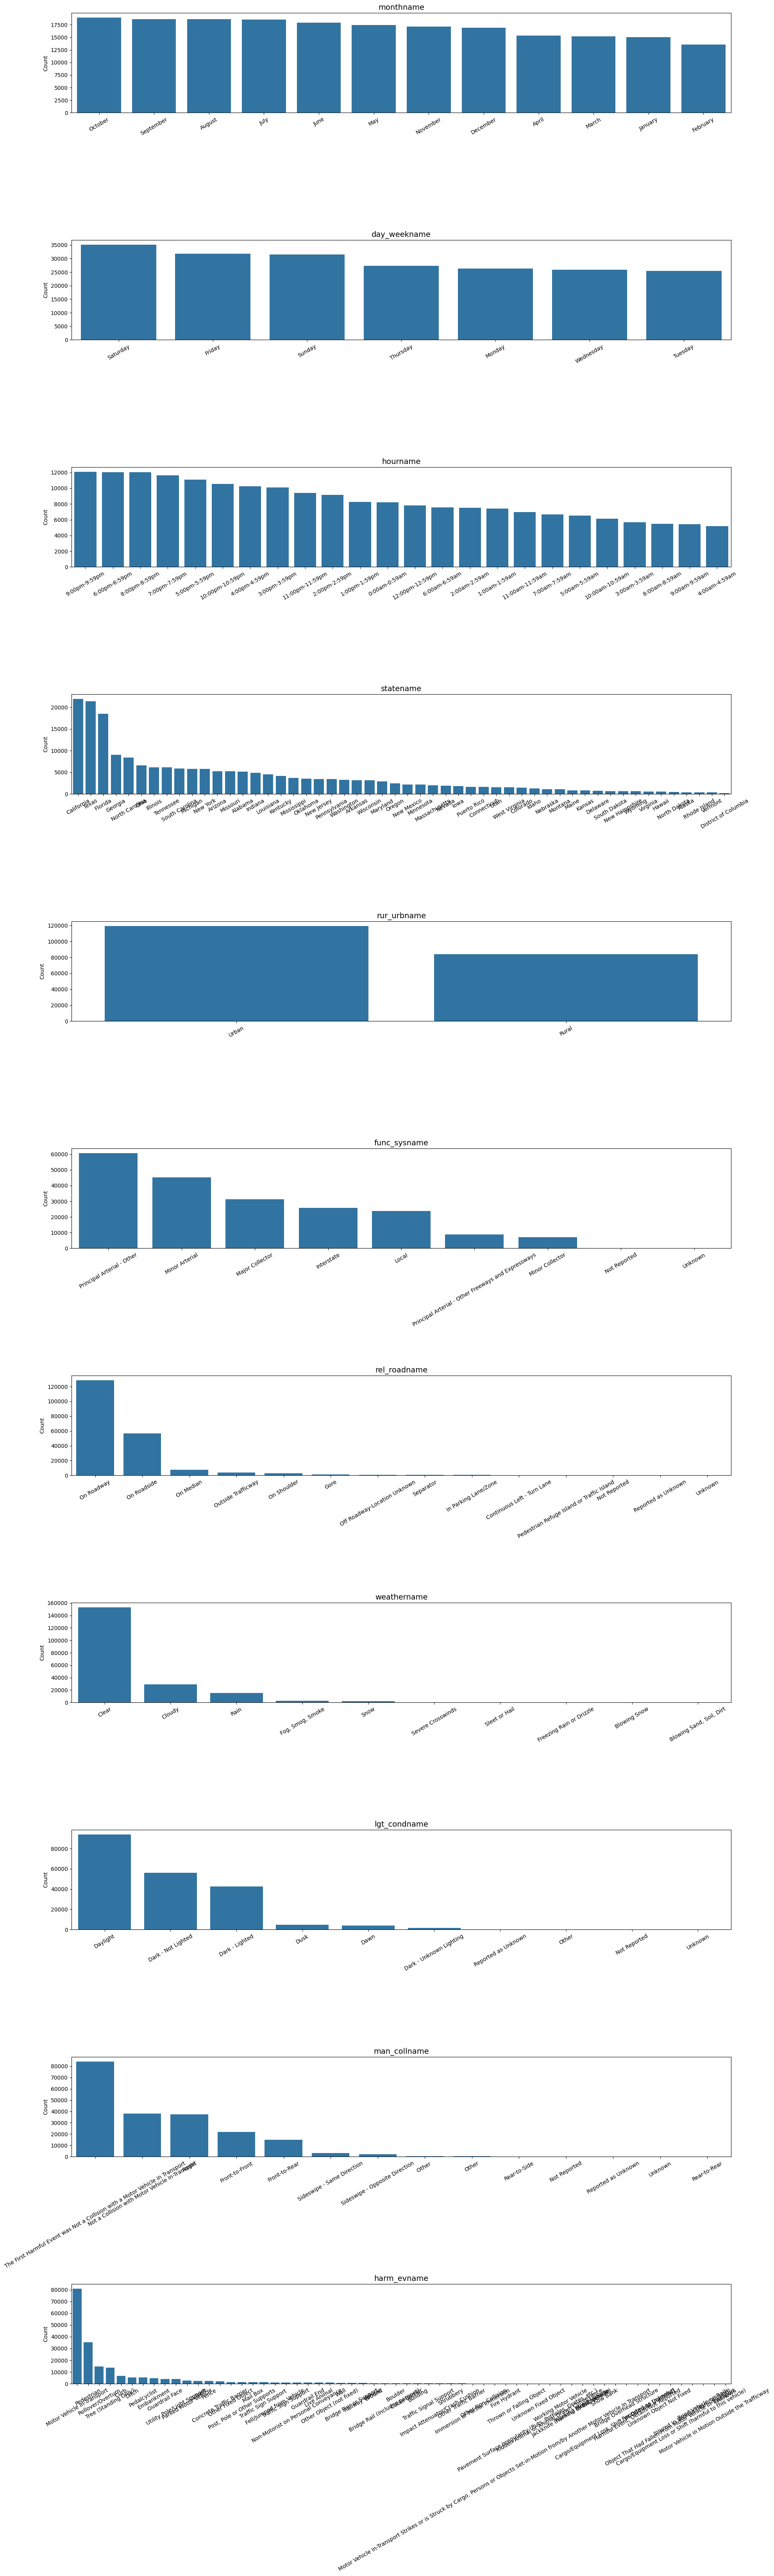

In [32]:
col_cat = ["monthname", "day_weekname", "hourname", "statename", "rur_urbname",
            "func_sysname", "rel_roadname", "weathername", "lgt_condname", 
            "man_collname", "harm_evname"]


dtype: object
n_rows = len(col_cat)
fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(20, 6 * n_rows))
fig.subplots_adjust(hspace=0.6)

if n_rows == 1:
    axes = [axes]

for i, col in enumerate(col_cat):
    sns.countplot(x=col, data=df, ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel("")  
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


Análisis Temporal de los Accidentes El análisis por meses muestra que julio, octubre y septiembre son los meses con mayor cantidad de accidentes, mientras que febrero registra la menor cantidad. Esta distribución sugiere una posible relación con las vacaciones de verano, la mayor movilidad en otoño y otros factores estacionales que incrementan el tráfico. En cuanto a los días de la semana, los sábados y viernes concentran más siniestros, lo cual podría estar vinculado a actividades sociales, recreativas y consumo de alcohol. Respecto a las horas del día, el mayor número de accidentes ocurre en las tardes, particularmente entre las 4:00 p.m. y las 6:00 p.m., coincidiendo con la hora pico de salida laboral. Por el contrario, las madrugadas muestran menor incidencia.

Distribución Geográfica de los Accidentes Los estados con más accidentes reportados son California, Texas y Florida, lo cual es coherente con su alta población y densidad vehicular. En contraste, estados pequeños o con menor población presentan cifras considerablemente más bajas. En términos de localización, la gran mayoría de los siniestros ocurren en zonas urbanas, lo que refleja la concentración de tráfico, infraestructura compleja y mayor interacción entre peatones, ciclistas y vehículos motorizados.

Infraestructura Vial y Tipos de Vía En relación con el tipo de vía, los accidentes se presentan con mayor frecuencia en arterias principales que no son autopistas, seguidas por vías arteriales menores y autopistas interestatales. Esto indica que las carreteras con tráfico intenso y múltiples intersecciones son escenarios frecuentes de colisiones. Además, la mayoría de los incidentes se produce directamente sobre la vía, aunque también hay una proporción considerable en los bordes o acotamientos, lo cual puede deberse a intentos de evasión o pérdida de control del vehículo.

Condiciones Ambientales en el Momento del Accidente Contrario a lo que podría esperarse, la mayoría de los accidentes se produce bajo condiciones climáticas normales, con el cielo despejado y en plena luz del día. Esto sugiere que factores como la conducta del conductor, la velocidad o la distracción son más determinantes que el clima en la ocurrencia de los siniestros. Aunque también se reportan accidentes en condiciones de oscuridad, estos son menos frecuentes.

Naturaleza de las Colisiones y Eventos Dañinos Las colisiones más frecuentes son las que involucran vehículos en movimiento, seguidas por eventos como salidas del camino y colisiones laterales. Esto refuerza la idea de que la interacción entre conductores, junto con errores de manejo, es una causa crítica. Asimismo, el evento dañino más común es la colisión con otro vehículo motorizado en tránsito, lo cual representa la principal fuente de lesiones y daños materiales.


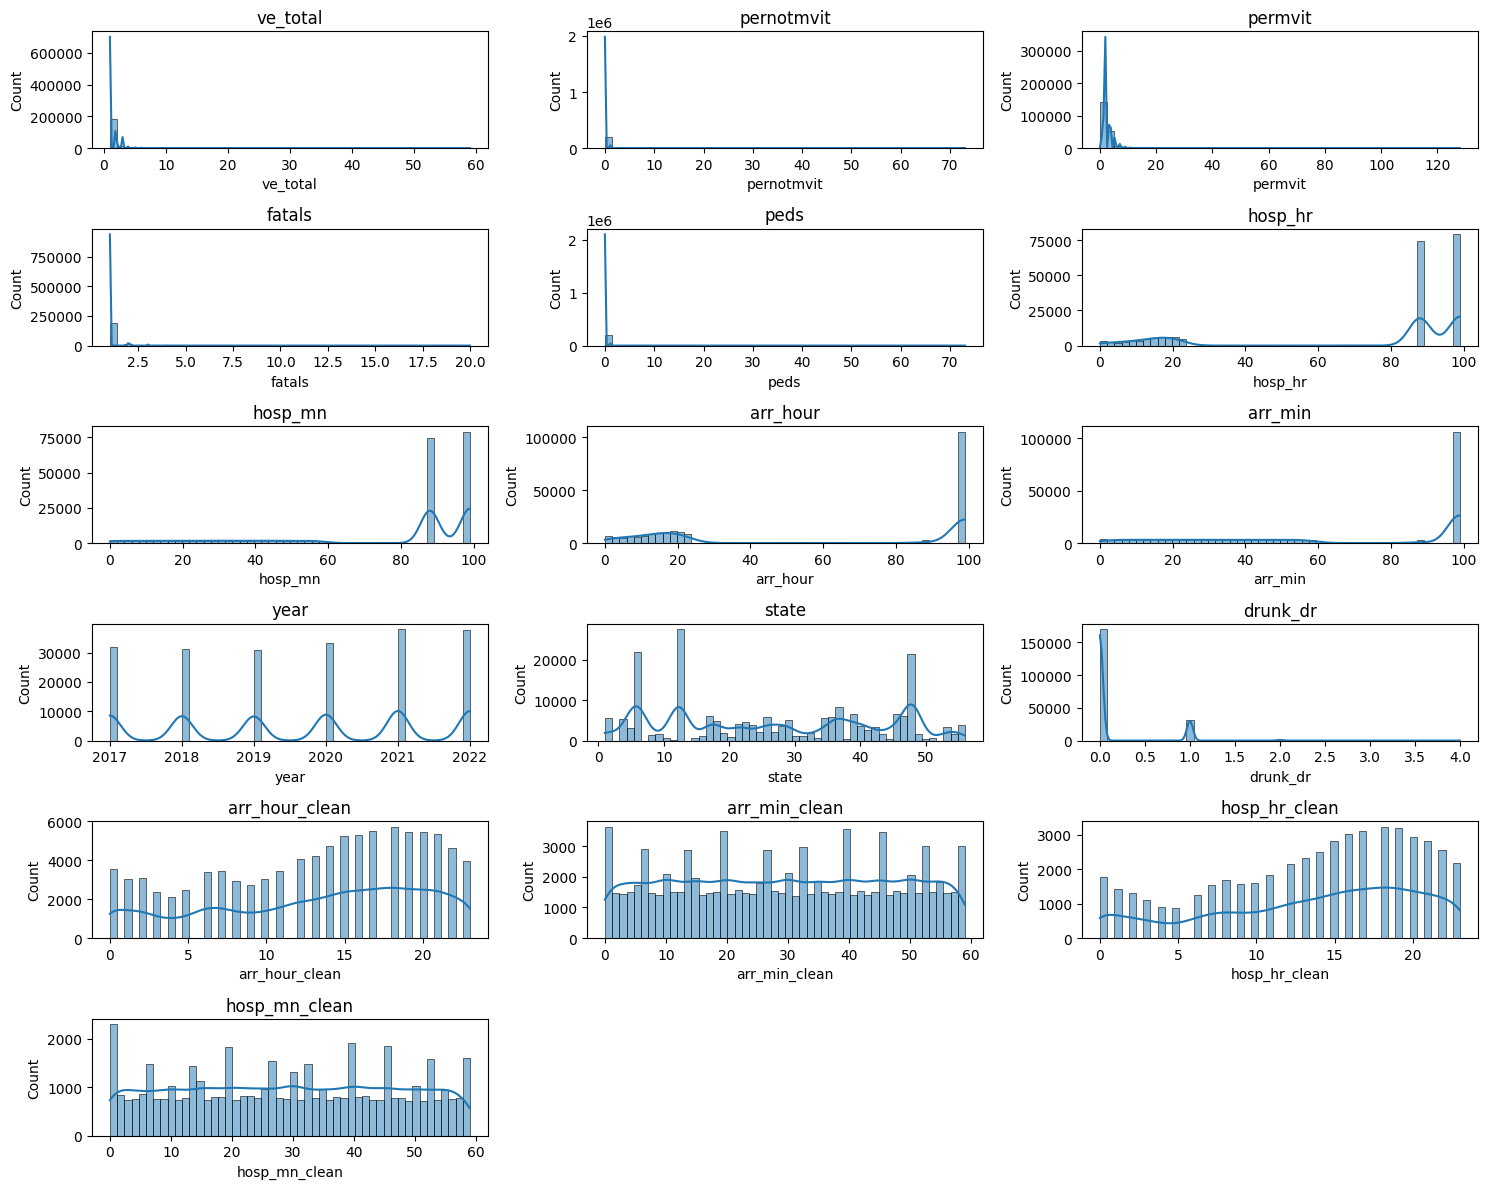

In [33]:
col_num = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 3
n_rows = math.ceil(len(col_num) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))
axes = axes.flatten()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, col in enumerate(col_num):
    nbins = 10 if col == 'age' else 50
    sns.histplot(x=col, data=df, ax=axes[i], bins=nbins, kde=True)
    axes[i].set_title(f"{col}", fontsize=12)

# Si sobran ejes (porque no llenamos el grid), los escondemos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Número de Vehículos Involucrados y Personas Afectadas La mayoría de los accidentes involucran solo uno o dos vehículos (ve_total), lo cual sugiere que los siniestros más comunes son colisiones simples o pérdidas de control individuales. En cuanto a la ocupación, tanto los vehículos con pasajeros permanentes (permvit) como no permanentes (pernotmvit) muestran concentraciones bajas, lo que indica que la mayoría de los autos implicados tienen pocos ocupantes. Esto podría relacionarse con accidentes en vehículos particulares más que en transporte público o vehículos con múltiples pasajeros.
Fatalidades y Peatones Afectados La mayoría de los accidentes no presentan fatalidades (fatals) ni peatones involucrados (peds), pero cuando los hay, se concentran en cifras muy bajas (uno o dos casos). Esto es coherente con la idea de que aunque los accidentes son frecuentes, la mayoría no son letales ni afectan a peatones, lo que apunta hacia choques vehiculares sin víctimas graves como el escenario más común.
Año del Accidente Los datos se concentran en los años 2017, 2018 y 2019, lo cual sugiere que el análisis cubre un periodo reciente de tres años. Cada año parece tener un número similar de registros, lo cual es útil para realizar comparaciones consistentes en el tiempo.
Distribución por Estado La variable state muestra una gran variación entre estados. Algunos estados presentan muchos más registros de accidentes, destacándose posiblemente California, Texas o Florida (aunque no se ve el nombre exacto en la gráfica), lo cual es esperable dada su población y tráfico. Otros estados tienen una incidencia considerablemente menor.
La variable arr_hour_clean, que representa la hora en la que ocurrió la llegada de los casos registrados, muestra una distribución que comienza a incrementarse notablemente desde el mediodía y alcanza su punto más alto entre las 16:00 y las 19:00 horas. Esto sugiere que la mayor cantidad de eventos posiblemente accidentes o situaciones que requieren atención médica tienden a suceder durante las horas de la tarde, probablemente debido al incremento en el tráfico vehicular.
En cuanto a la variable arr_min_clean, que indica el minuto exacto dentro de la hora en que ocurre la llegada, se observa una distribución bastante uniforme, aunque con ciertos picos evidentes en múltiplos de cinco (como 0, 5, 10, etc.). Esta concentración en minutos específicos sugiere que los datos podrían haber sido redondeados o registrados con una resolución temporal baja,
La variable hosp_hr_clean refleja la hora a la que los individuos fueron hospitalizados. Esta distribución es muy similar a la de la hora de llegada, con un aumento progresivo de casos desde el mediodía y un pico importante entre las 14:00 y las 20:00 horas. Esto refuerza la idea de que los eventos que requieren hospitalización suceden con mayor frecuencia durante la tarde.
Respecto a la variable hosp_mn_clean, los datos muestran nuevamente una distribución uniforme con algunos picos repetidos en valores que corresponden a múltiplos de cinco. Esto coincide con el comportamiento de arr_min_clean y respalda la hipótesis de que los registros fueron sistemáticamente redondeados o capturados en intervalos regulares.
La variable drunk_dr, que representa si hubo conducción bajo los efectos del alcohol, muestra una distribución altamente sesgada hacia el valor 0. Esto indica que, en la mayoría de los registros, no se reportó consumo de alcohol por parte del conductor. Aun así, existe una fracción considerable de casos con valor 1, lo cual señala la presencia de eventos donde sí se confirmó que el conductor había consumido alcohol. Además, se observan algunos valores superiores a 1 (hasta 4). 


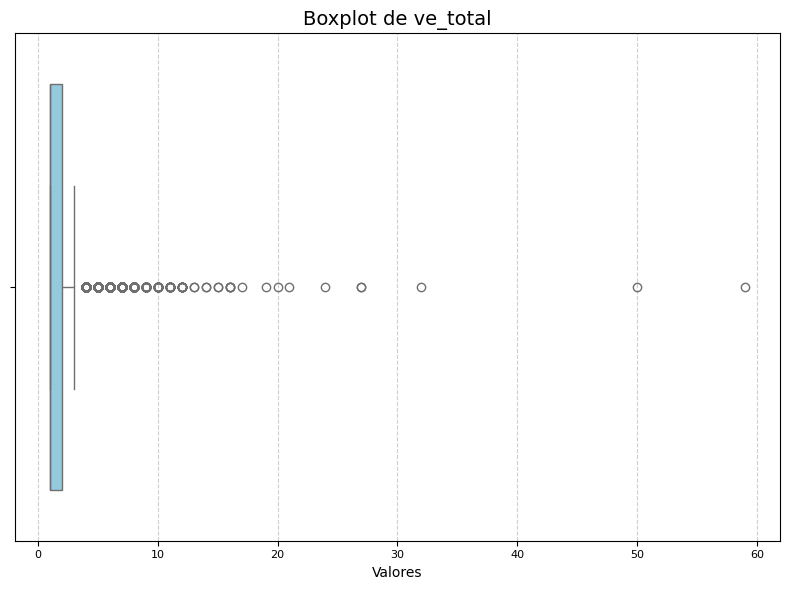

Outliers en ve_total:
        ve_total
22             4
143            4
206            4
228            4
338            4
...          ...
218558         6
218595         5
218639        10
218644         6
218763         4

[4914 rows x 1 columns]
Número de outliers: 4914
------------------------------


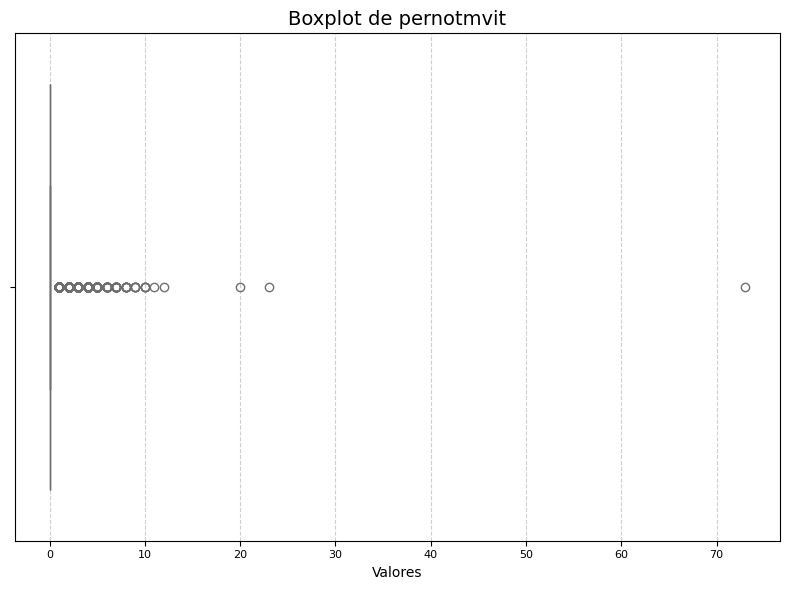

Outliers en pernotmvit:
        pernotmvit
9                1
26               1
39               1
45               1
52               1
...            ...
218673           1
218719           2
218730           1
218764           1
218771           2

[45789 rows x 1 columns]
Número de outliers: 45789
------------------------------


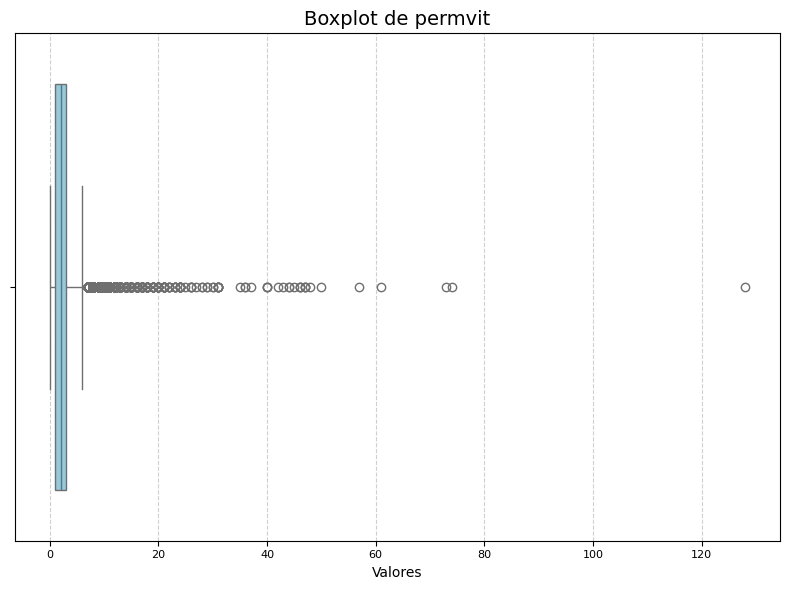

Outliers en permvit:
        permvit
88            7
89            7
178           7
186           7
206           8
...         ...
218595       11
218602        8
218639       14
218643        7
218763       14

[5008 rows x 1 columns]
Número de outliers: 5008
------------------------------


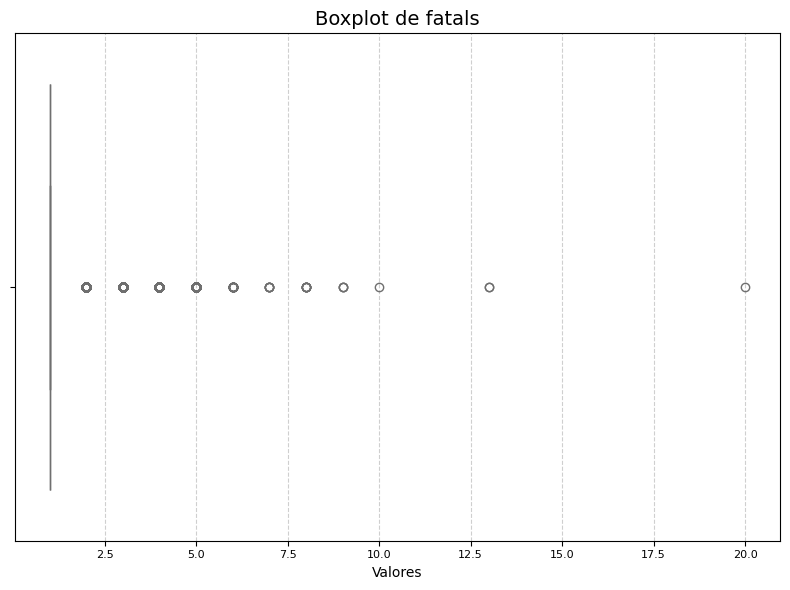

Outliers en fatals:
        fatals
10           2
12           2
34           2
40           2
41           2
...        ...
218731       2
218739       3
218741       2
218745       2
218747       2

[14292 rows x 1 columns]
Número de outliers: 14292
------------------------------


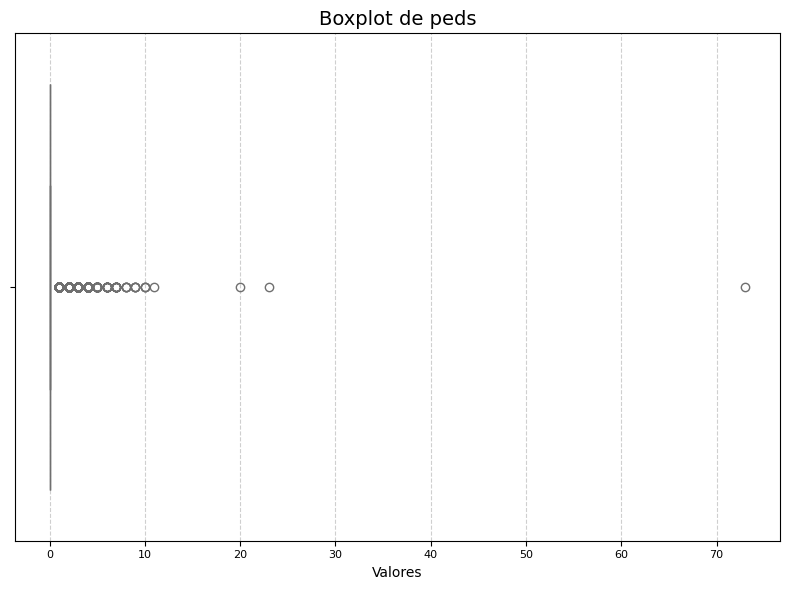

Outliers en peds:
        peds
9          1
26         1
39         1
45         1
52         1
...      ...
218673     1
218719     2
218730     1
218764     1
218771     2

[44643 rows x 1 columns]
Número de outliers: 44643
------------------------------


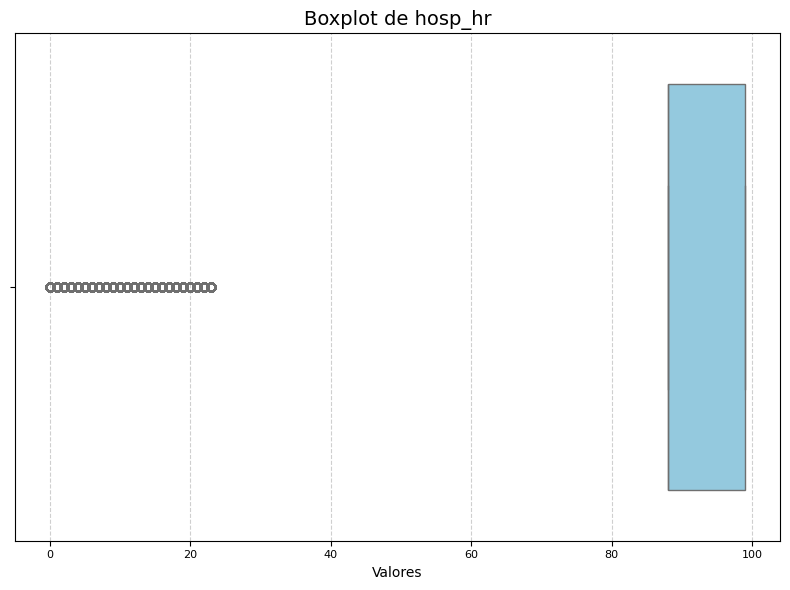

Outliers en hosp_hr:
        hosp_hr
4            21
19           23
24            1
30           14
34            4
...         ...
218765       11
218770       18
218772       12
218774       15
218776        6

[49777 rows x 1 columns]
Número de outliers: 49777
------------------------------


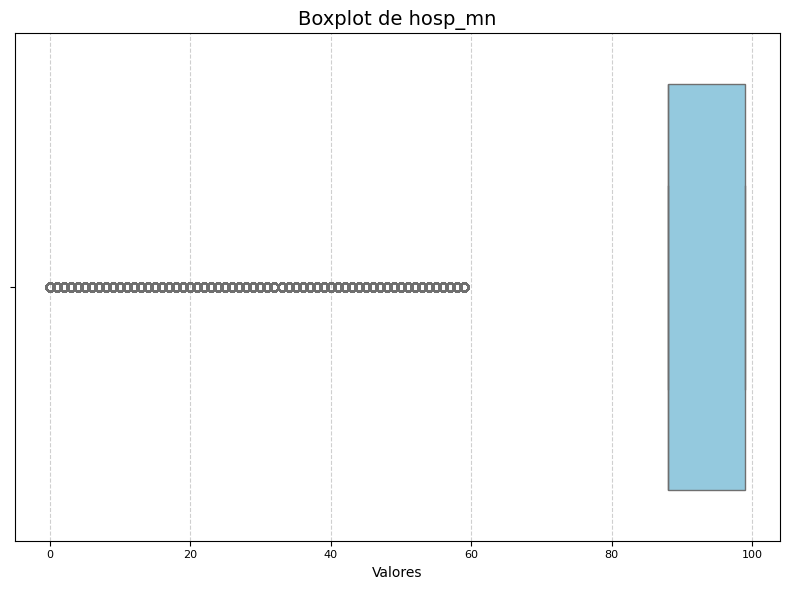

Outliers en hosp_mn:
        hosp_mn
4            11
19           51
24           46
30           27
34           39
...         ...
218765       28
218770        5
218772        4
218774       27
218776       45

[49664 rows x 1 columns]
Número de outliers: 49664
------------------------------


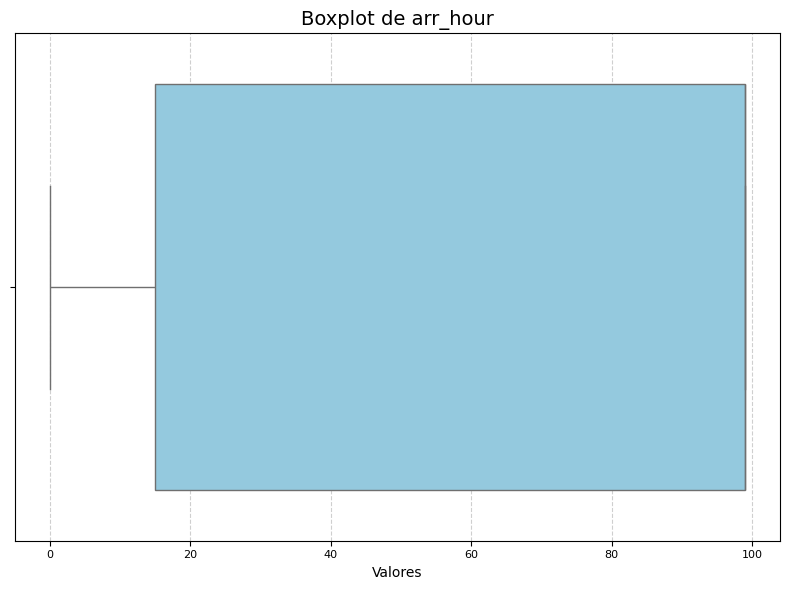

No se encontraron outliers en arr_hour
------------------------------


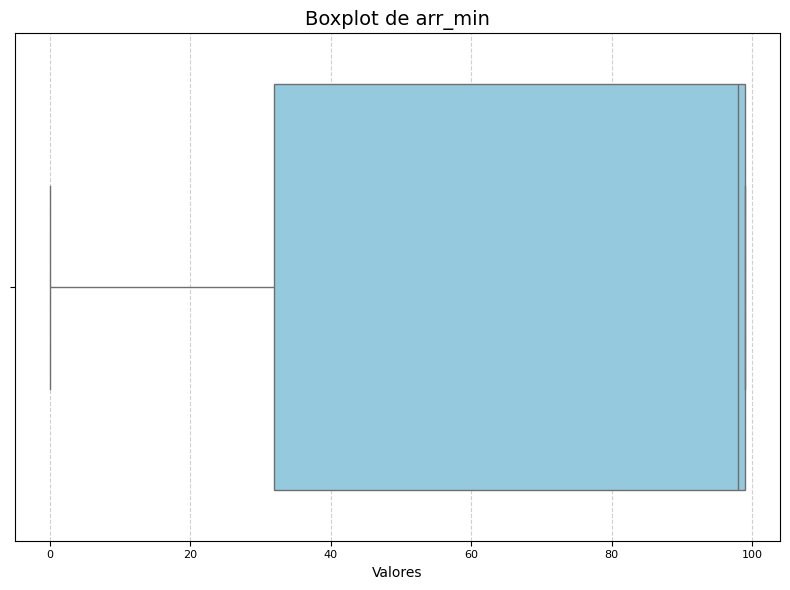

No se encontraron outliers en arr_min
------------------------------


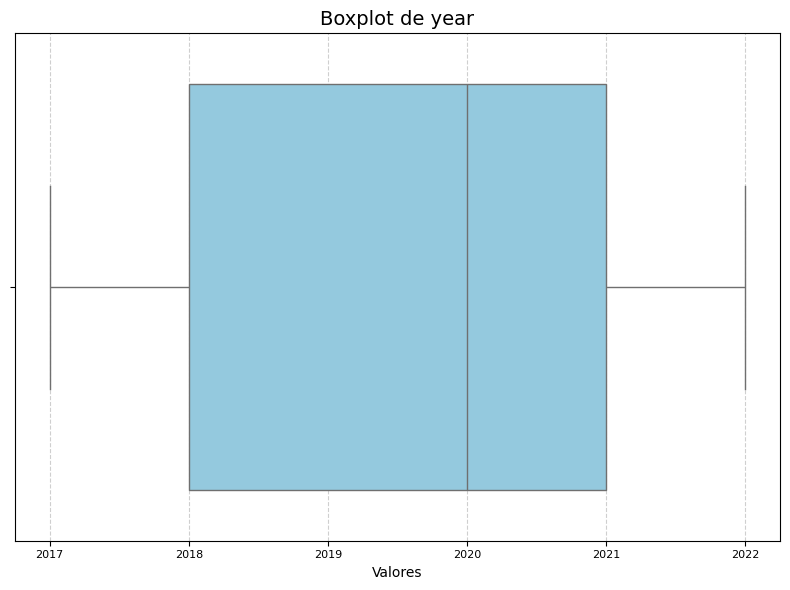

No se encontraron outliers en year
------------------------------


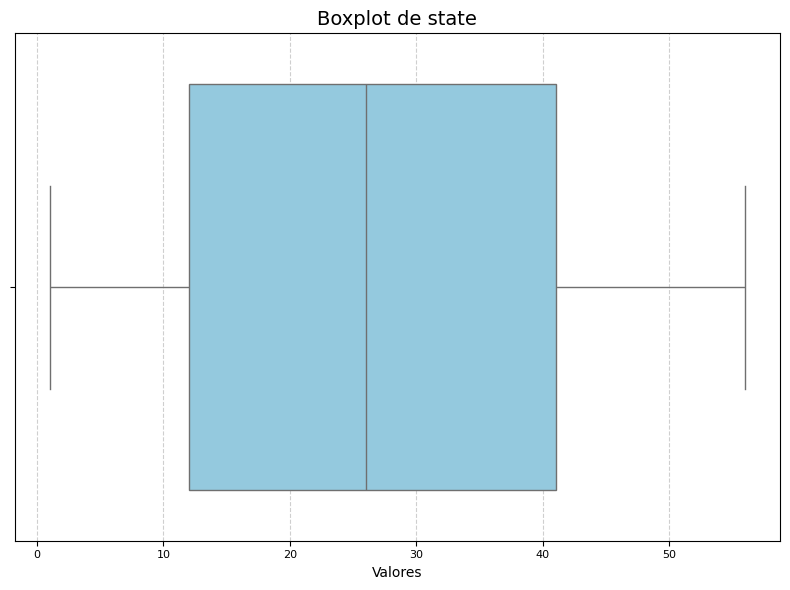

No se encontraron outliers en state
------------------------------


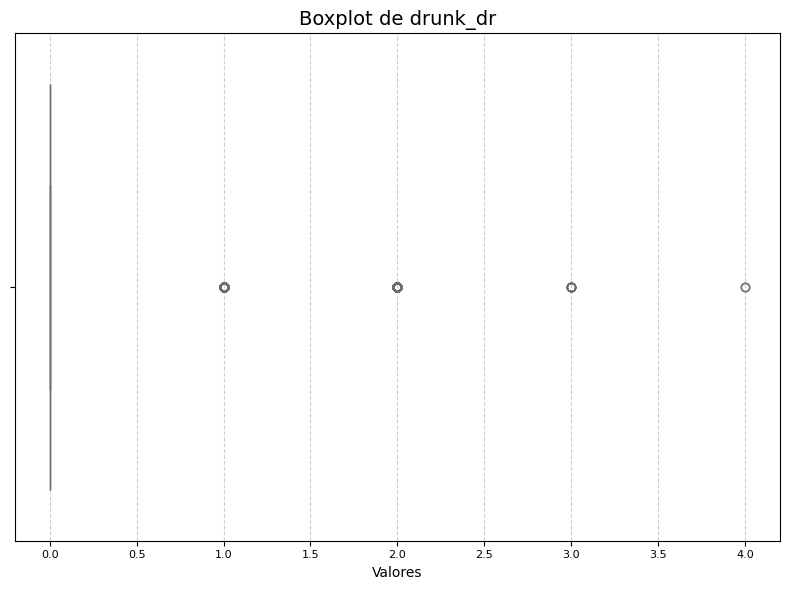

Outliers en drunk_dr:
        drunk_dr
12           1.0
13           1.0
14           1.0
16           1.0
20           1.0
...          ...
138959       1.0
138962       1.0
138970       1.0
138973       1.0
138974       1.0

[33169 rows x 1 columns]
Número de outliers: 33169
------------------------------


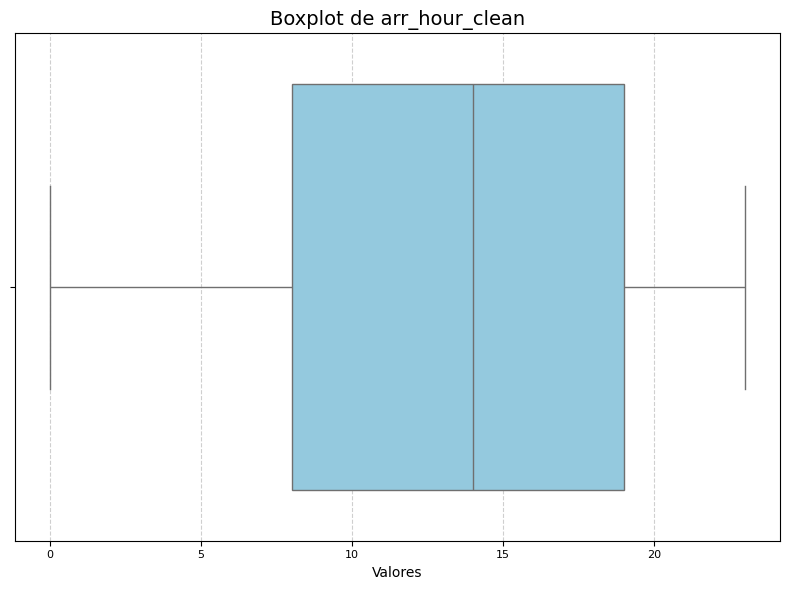

No se encontraron outliers en arr_hour_clean
------------------------------


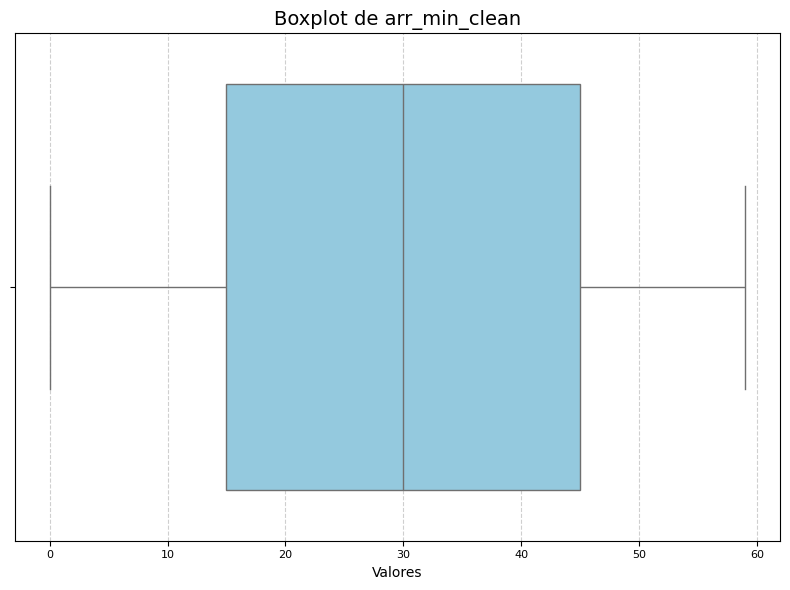

No se encontraron outliers en arr_min_clean
------------------------------


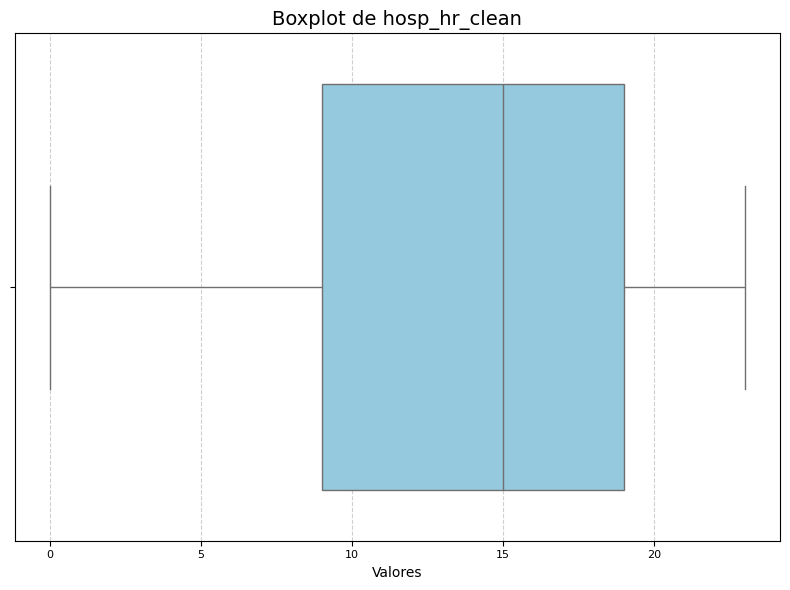

No se encontraron outliers en hosp_hr_clean
------------------------------


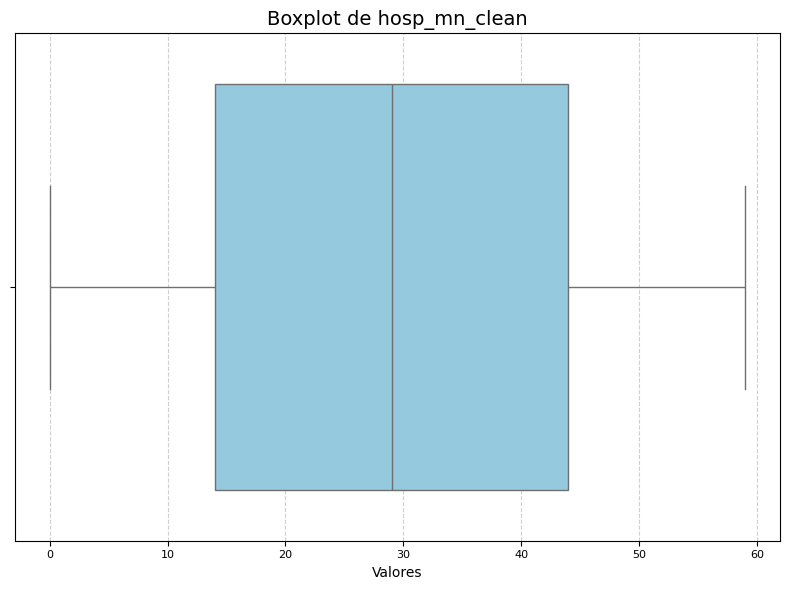

No se encontraron outliers en hosp_mn_clean
------------------------------


In [34]:
numerical_cols = df.select_dtypes(include=['int64', 'float64'])
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col], color='skyblue')  
    plt.title(f'Boxplot de {col}', fontsize=14)
    plt.xlabel('Valores', fontsize=10)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.xticks(fontsize=8)
    plt.tight_layout()
    plt.show()

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    if not outliers.empty:
        print(f"Outliers en {col}:")
        print(outliers[[col]])
        print(f"Número de outliers: {len(outliers)}")
        print("-" * 30)
    else:
        print(f"No se encontraron outliers en {col}")
        print("-" * 30)

Los outliers en la variable ve_total, que representa el número total de vehículos involucrados en un accidente, son valores que se alejan significativamente del rango típico de esta variable. Como se observa en el boxplot, la mayoría de los datos están concentrados en los valores más bajos (entre 1 y 3 vehículos), mientras que hay una gran cantidad de valores atípicos (outliers) hacia la derecha del gráfico, que representan accidentes con un número inusualmente alto de vehículos involucrados. En total, se identificaron 3.055 outliers, lo cual sugiere que aunque no son casos frecuentes, sí ocurren con relativa regularidad accidentes con múltiples vehículos.
Los outliers en pernotmvit revelan que, aunque es poco común, en ciertos accidentes se ven involucradas muchas personas no motorizadas (como peatones o ciclistas). Estos casos extremos son importantes para investigar más a fondo, ya que podrían corresponder a accidentes masivos o eventos en zonas con alta presencia peatonal.
La variable permvit, presenta una distribución altamente sesgada hacia valores bajos, tal como se observa en su boxplot. La mayoría de los valores se agrupan cerca del extremo inferior, y existe una gran cantidad de valores atípicos (outliers) hacia la derecha, algunos incluso mayores a 120. Este comportamiento indica una gran dispersión y una alta variabilidad en la variable, con una concentración de datos en valores bajos pero con casos extremos que se alejan significativamente del resto.
El boxplot de la variable peds revela una gran cantidad de valores atípicos (27,755), los cuales representan accidentes en los que al menos un peatón estuvo involucrado. La mayoría de estos outliers tienen el valor de 1, lo que indica que en muchos casos fue solo un peatón el afectado; sin embargo, también se observan valores más extremos, como 10 o hasta 22 peatones involucrados en un solo evento.
La variable fatals, que representa el número de fallecidos en un evento (presumiblemente accidentes de tránsito), muestra una distribución fuertemente asimétrica y concentrada en valores bajos, especialmente en 0 o 1. El boxplot evidencia una gran cantidad de valores atípicos (outliers), ya que cualquier valor superior a 1 es considerado fuera del rango intercuartílico. lo cual es una cifra considerable. Estos valores atípicos van desde 2 hasta un máximo de 20 fallecidos en un solo evento, lo que refleja casos excepcionales pero significativos en términos de gravedad.
El boxplot de la variable year abarca desde 2017.0 hasta 2022.0, con la mediana ubicada alrededor de 2019, lo que indica un período de estudio de aproximadamente tres años. Este rango temporal sugiere que los datos están distribuidos de manera equilibrada, donde el 50% de los registros ocurrieron antes de 2019 y el otro 50% después de ese año. La ausencia de outliers confirma que no hay valores atípicos que se extiendan más allá de los límites esperados (antes de 2017 o después de 2022), lo que refleja una recopilación de datos consistente y sin anomalías temporales. Si la variable representa datos anuales, la mediana en 2019 señala que este año concentra la mayor cantidad de registros, con una distribución uniforme antes y después de ese punto.
El boxplot de la variable drunk_dr (nivel de embriaguez del conductor) muestra una distribución donde la gran mayoría de valores se concentran en 0.0. Si bien la conducción en estado de ebriedad no es la norma, sigue siendo un problema recurrente que merece atención. La ausencia de outliers en niveles más altos (2.0-4.0) implica que los casos graves de embriaguez al volante son estadísticamente menos frecuentes en este conjunto de datos.
El boxplot de la variable arr_hour_clean, que representa la hora limpia o depurada de llegada (posiblemente al lugar del accidente o del reporte), muestra una distribución bastante uniforme y sin valores atípicos. La mediana se sitúa aproximadamente en las 14 horas (2:00 p.m.), lo que indica que la mitad de los eventos ocurrieron antes y la otra mitad después de esa hora. El rango intercuartílico abarca desde aproximadamente las 8 hasta las 20 horas, sugiriendo que la mayoría de los eventos se concentran entre la mañana media y el final de la tarde.
El boxplot de la variable arr_min_clean, que representa el minuto limpio o depurado de llegada, muestra una distribución bastante uniforme a lo largo del rango esperado (0–59 minutos). La mediana se sitúa alrededor del minuto 30, lo que indica una distribución simétrica y balanceada entre los minutos del reloj. El rango intercuartílico va desde aproximadamente el minuto 15 hasta el 45, lo que sugiere que la mayoría de los registros de llegada se encuentran dentro de ese intervalo.
El boxplot de la variable hosp_hr_clean, que representa la hora en la que las personas fueron hospitalizadas, muestra una distribución bastante amplia, que va desde las 0 horas hasta aproximadamente las 23 horas. La mediana está alrededor de las 14 o 15 horas, lo que indica que la mayoría de las hospitalizaciones ocurrieron en horas de la tarde. El rango intercuartílico se extiende desde aproximadamente las 9 hasta las 20 horas. Esto sugiere que el grueso de los casos ocurrió durante el día, en un horario laboral o de mayor actividad.
El boxplot de la variable hosp_mn_clean, que representa los minutos en los que ocurrieron las hospitalizaciones dentro de la hora, muestra una distribución simétrica y uniforme, con la mediana ubicada en torno a los 30 minutos. El rango intercuartílico se extiende aproximadamente entre los 15 y 45 minutos, lo cual indica que la mayoría de los eventos se concentran en ese intervalo. Además, no se identifican valores atípicos (outliers). 


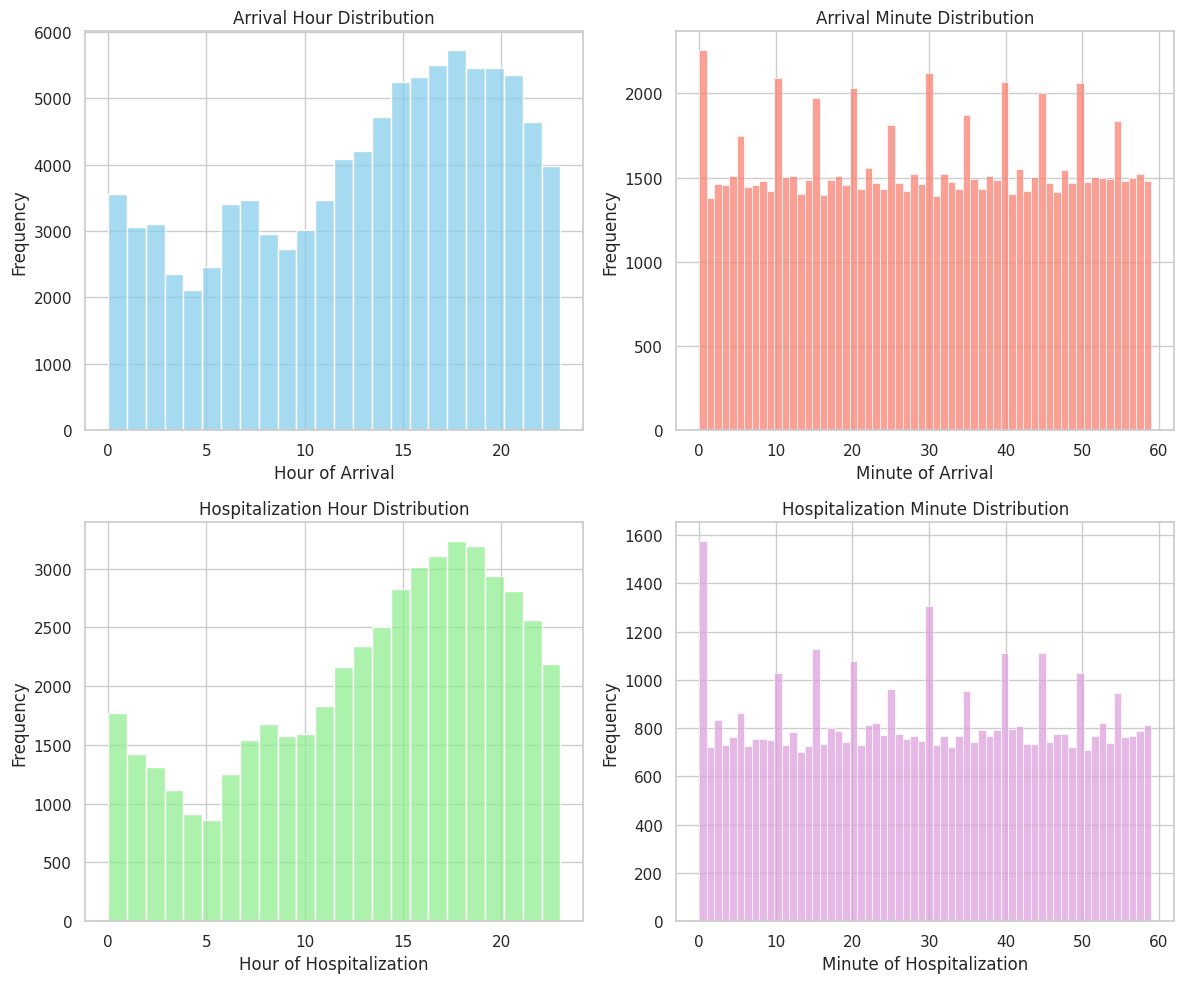

In [35]:
sns.set(style="whitegrid")

# Tamaño general de los gráficos
plt.figure(figsize=(12, 10))

# Histograma 1: arr_hour
plt.subplot(2, 2, 1)
sns.histplot(df['arr_hour_clean'], bins=24, kde=False, color="skyblue")
plt.title('Arrival Hour Distribution')
plt.xlabel('Hour of Arrival')
plt.ylabel('Frequency')

# Histograma 2: arr_min
plt.subplot(2, 2, 2)
sns.histplot(df['arr_min_clean'], bins=60, kde=False, color="salmon")
plt.title('Arrival Minute Distribution')
plt.xlabel('Minute of Arrival')
plt.ylabel('Frequency')

# Histograma 3: hosp_hr
plt.subplot(2, 2, 3)
sns.histplot(df['hosp_hr_clean'], bins=24, kde=False, color="lightgreen")
plt.title('Hospitalization Hour Distribution')
plt.xlabel('Hour of Hospitalization')
plt.ylabel('Frequency')

# Histograma 4: hosp_mn
plt.subplot(2, 2, 4)
sns.histplot(df['hosp_mn_clean'], bins=60, kde=False, color="plum")
plt.title('Hospitalization Minute Distribution')
plt.xlabel('Minute of Hospitalization')
plt.ylabel('Frequency')

# Ajuste final
plt.tight_layout()
plt.show()

Las gráficas muestran una clara concentración de incidentes en las primeras horas del día (0-5 horas), con una disminución progresiva a medida que avanza el día, tanto en las horas de llegada como de hospitalización, lo que sugiere una mayor incidencia de eventos durante la madrugada. En cuanto a los minutos, la distribución es más uniforme, aunque con un ligero pico en los primeros 10-20 minutos, indicando que los primeros momentos tras el incidente son críticos. Estos patrones consistentes entre llegada y hospitalización reflejan que la mayoría de los casos ocurren en horario nocturno, posiblemente asociados a factores como conducción bajo efectos del alcohol, y no evidencian retrasos significativos en la atención médica una vez que los pacientes llegan al centro asistencial.

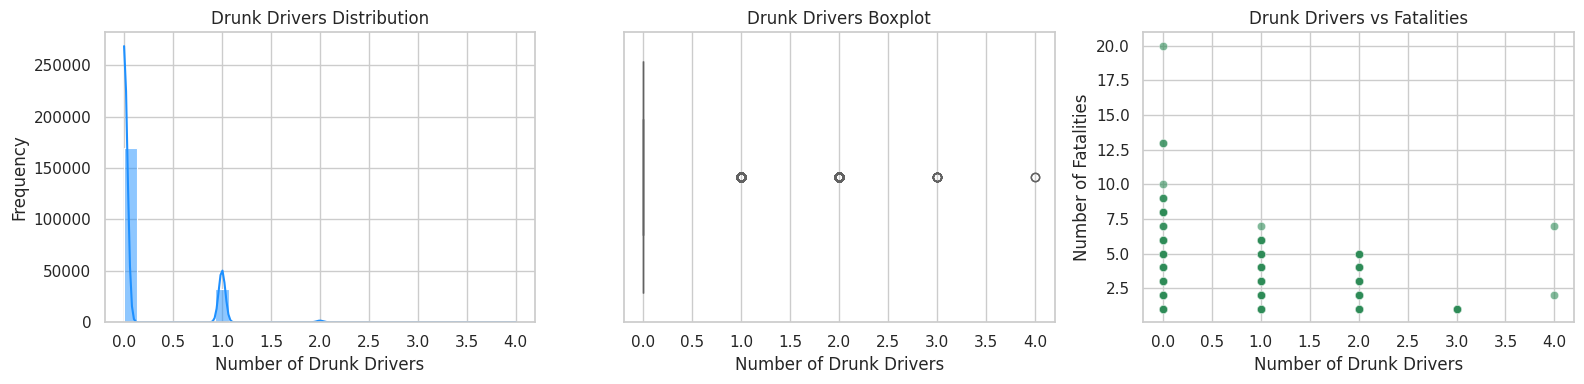

In [36]:
# Histograma de drunk_dr
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.histplot(df['drunk_dr'].dropna(), bins=30, kde=True, color="dodgerblue")
plt.title('Drunk Drivers Distribution')
plt.xlabel('Number of Drunk Drivers')
plt.ylabel('Frequency')

# Boxplot de drunk_dr
plt.subplot(1, 3, 2)
sns.boxplot(x=df['drunk_dr'], color="tomato")
plt.title('Drunk Drivers Boxplot')
plt.xlabel('Number of Drunk Drivers')

# Scatter plot: drunk_dr vs fatals
plt.subplot(1, 3, 3)
sns.scatterplot(x='drunk_dr', y='fatals', data=df, alpha=0.6, color="seagreen")
plt.title('Drunk Drivers vs Fatalities')
plt.xlabel('Number of Drunk Drivers')
plt.ylabel('Number of Fatalities')

plt.tight_layout()
plt.show()


El gráfico revela que la gran mayoría de conductores (150,000-170,000 casos) están sobrios (0.0), mientras que la frecuencia disminuye drásticamente a medida que aumenta el nivel de alcohol, con apenas 50,000 casos en nivel 1.0 y cantidades insignificantes en niveles superiores (2.0-4.0). El boxplot confirma que los casos con alcohol son atípicos, destacando que incluso niveles bajos (1.0) tienen un impacto desproporcionado en la seguridad vial. Estos hallazgos subrayan la importancia de mantener políticas estrictas contra la conducción bajo efectos del alcohol, ya que, aunque son minoritarios, estos casos representan un riesgo significativo para la seguridad pública.

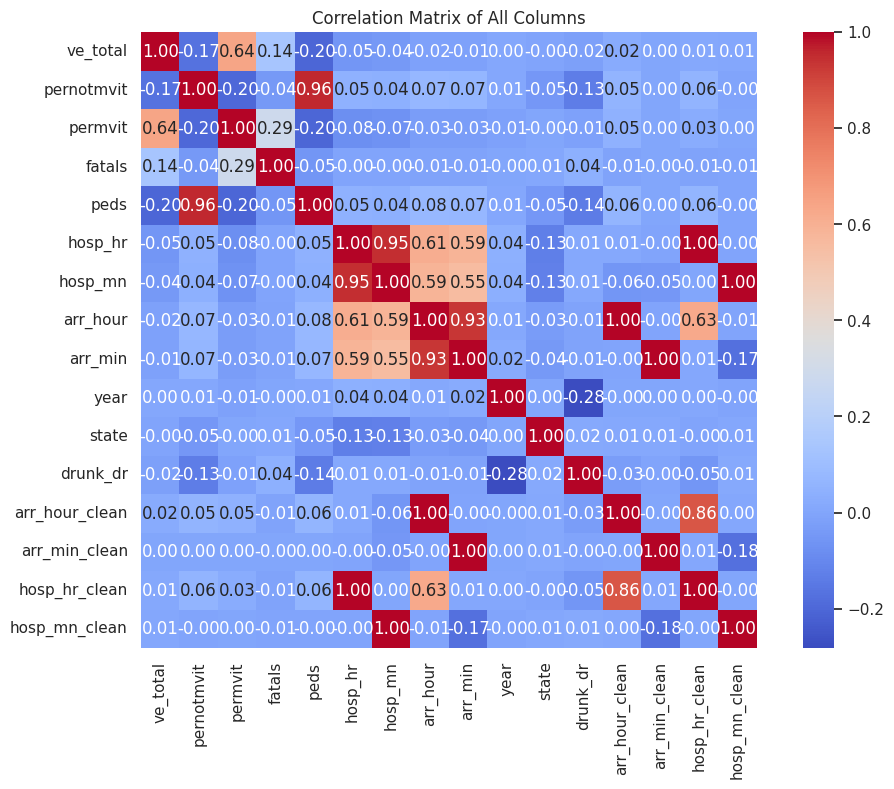

In [37]:
correlation_matrix = numerical_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Mat' \
'rix of All Columns')
plt.show()

# Transformations for the dimensional modeling

In [ ]:
df = df.drop(columns=['hosp_hr', 'hosp_mn','state', 'statename','man_collname'])